In [115]:
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()
tf.test.gpu_device_name()

2.2.0


''

In [121]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b

In [117]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top= False)
    
  new_model = Sequential()
  n = 0
  for layer in vgg.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if layer.__class__ == MaxPooling2D:
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)
    if n >= num_convs:
      break
  return new_model  

In [141]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [119]:
def scale_img(x):
  x = x - x.min()
  x = x/x.max()
  return x


In [154]:
if __name__ == '__main__':
  path = 'Akpa2.png'
  img = image.load_img(path)
    
  # convert to array
  x = image.img_to_array(img)
  print(x.shape)  
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  batch_shape = x.shape
  shape = batch_shape[1:]

  # choose layer to get output
  content_model = VGG16_AvgPool_CutOff(shape, 6)

  target = K.variable(content_model.predict(x))
  print(content_model.output)
  loss = K.mean(K.square(target - content_model.output))

  grads = K.gradients(loss, content_model.input)

  get_loss_and_grads = K.function(
      inputs = [content_model.input],
      outputs = [loss] + grads 
  )

  def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


  from datetime import datetime
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(10):
    x, l, _ = fmin_l_bfgs_b(func = get_loss_and_grads_wrapper, x0=x, maxfun=20)
    x = np.clip(x, -127, 127)
    print("iter={} loss={}".format(i, l))
    losses.append(l)

(256, 256, 3)
Tensor("block3_conv2_22/Relu:0", shape=(None, 64, 64, 256), dtype=float32)
iter=0 loss=13094.74609375
iter=1 loss=6897.265625
iter=2 loss=4859.5595703125
iter=3 loss=3843.466064453125
iter=4 loss=3147.1005859375
iter=5 loss=2652.061279296875
iter=6 loss=2200.53515625
iter=7 loss=1805.8948974609375
iter=8 loss=1456.7578125
iter=9 loss=1225.32568359375


duartion:  0:07:59.750787


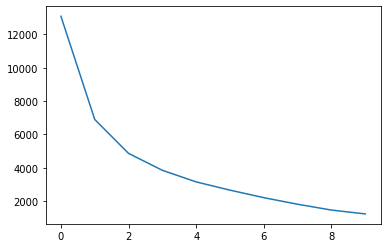

type of x: <class 'numpy.ndarray'>
<class 'numpy.ndarray'>


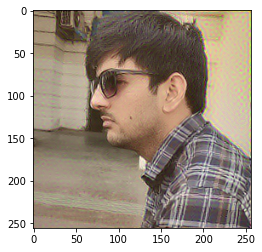

In [156]:
  print('duartion: ', datetime.now() - t0)
  plt.plot(losses)
  plt.show()    
  print('type of x: ' + str(type(x)))
  new_img = x.reshape(*batch_shape)
  final_img = unpreprocess(new_img)
  print(type(final_img))
  plt.imshow(scale_img(final_img[0]))
  plt.show()